# Advance Lane Finding

### Udacity Self-Driving Car Engineer Nanodegree Program

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

## Writeup / README

### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

---

## Overview

This project was done as part of the Udacity Self-Driving Car Engineer Nanodegree Program, where intent was to find the *EGO lane* (my vehicle's lane) and it's curvature all the time, along with the vehicle position within lane.

In order to achieve this I have used various techiques for finding lane markers from the image accurately to transform that into binary image. I have used gradient, hls' s-channel, gradient magnitude, gradient directions thresholding techniques to find lane lines. After that I have applied persepctive transform to transform lane view to bird's eye view (top-down) to find the lane curvature.

In order to measure the curvature I required to distort the image using camera calibration matrix which I have computed too. Using which I was able to translate distance from pixels unit to meter unit.



In [1]:
# some library imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import glob
import math

%matplotlib inline

#### Helper Functions

In [2]:
def showImages(images, cols = 4, rows = 5, figsize=(15, 10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.tight_layout()
    
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if len(image.shape) > 2:# cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap='gray')
            ax.set_title(imagePathName)
            ax.axis('off')
            
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Camera Calibrations

### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

For purpose of camera calibration I have used OpenCV APIs `findChessboardCorners` and `calibrateCamera`. First I collected all the image points by detecting chessboard corners with `findChessboardCorners` and it's respective objpoint. Once obtained, I fed these points to `calibrateCamera` to generate Calibration Matrices as given in below cell:

In [3]:
def cameraCalibration(image_dir, nx=9, ny=6):

    assert os.path.exists(image_dir), "%s does not exist" % (image_dir)

    fileList = glob.glob("%s/*.jpg" % (image_dir))
    assert len(fileList) > 0, "No calibration images found"

    pattern_points = np.zeros(shape=(nx * ny, 3), dtype=np.float32)
    pattern_points[:, :2] = np.indices(dimensions=(nx, ny)).T.reshape(-1, 2)

    objectPoints = []
    imagePoints = []
    for fileName in fileList:
        image = cv2.imread(fileName)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        h, w = image.shape[:2]
        found, corners = cv2.findChessboardCorners(gray, (nx, ny))
        if not found:
            continue

        imagePoints.append(corners.reshape(-1, 2))
        objectPoints.append(pattern_points)

    assert len(objectPoints) > 0, "chessboard not found"
    assert len(imagePoints) > 0, "chessboard not found"

    rms, mtx, dist, rvec, tvec = cv2.calibrateCamera(objectPoints=objectPoints,
                                                     imagePoints=imagePoints,
                                                     imageSize=(w, h),
                                                     cameraMatrix=None,
                                                     distCoeffs=None)

    with open('camera_calib.p', mode='wb') as fp:
        pickle.dump({'rms': rms, 'mtx': mtx, 'dist': dist, 'rvec': rvec, 'tvec': tvec}, fp)

cameraCalibration(image_dir="camera_cal")

In [4]:
with open("./camera_calib.p", mode='rb') as fp:
    calib = pickle.load(fp)
    
mtx = calib['mtx']
dist = calib['dist']

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

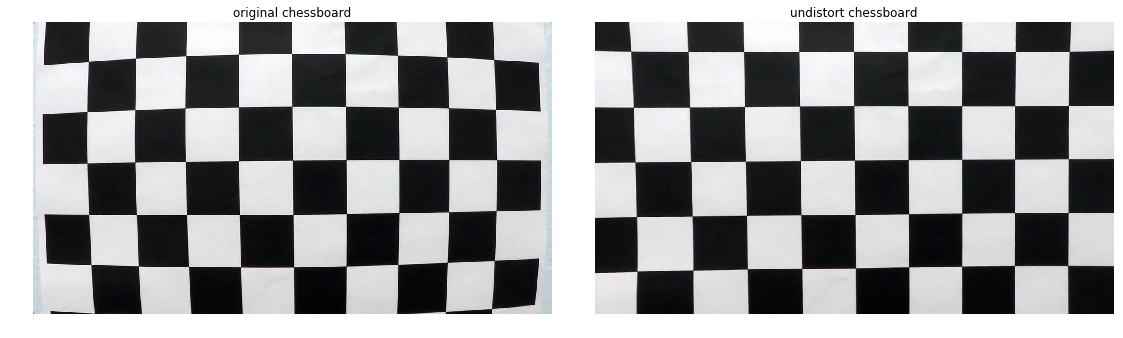

In [5]:
chessboard = cv2.imread("camera_cal/calibration1.jpg")
undist_chessboard = cv2.undistort(chessboard, mtx, dist)
showImages([("original chessboard", chessboard), ("undistort chessboard", undist_chessboard)], 2, 1)

### Test Images

Display all the test images

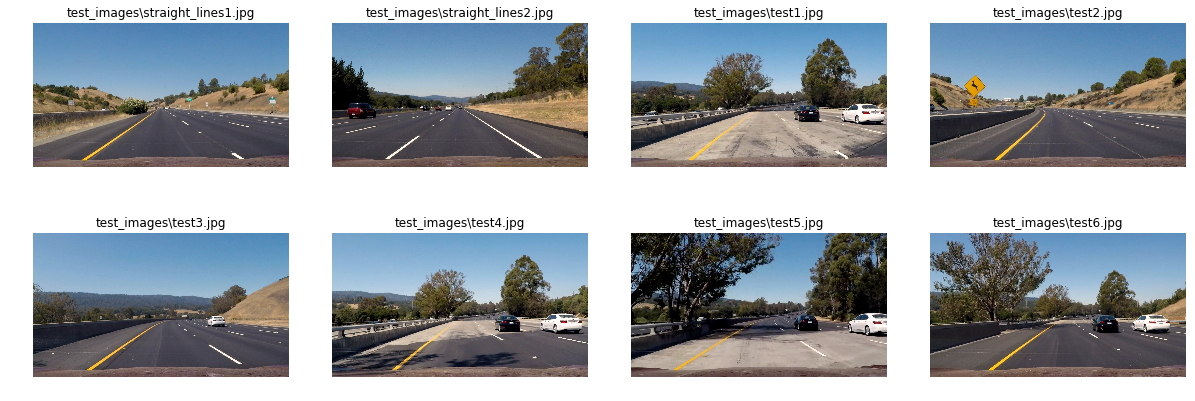

In [6]:
testImages = [(fileName, cv2.cvtColor(cv2.imread(fileName), cv2.COLOR_BGR2RGB)) for fileName in glob.glob("test_images/*.jpg")]
showImages(testImages, 4, 2, figsize=(16, 6))

## Pipeline (single images)

### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one: 

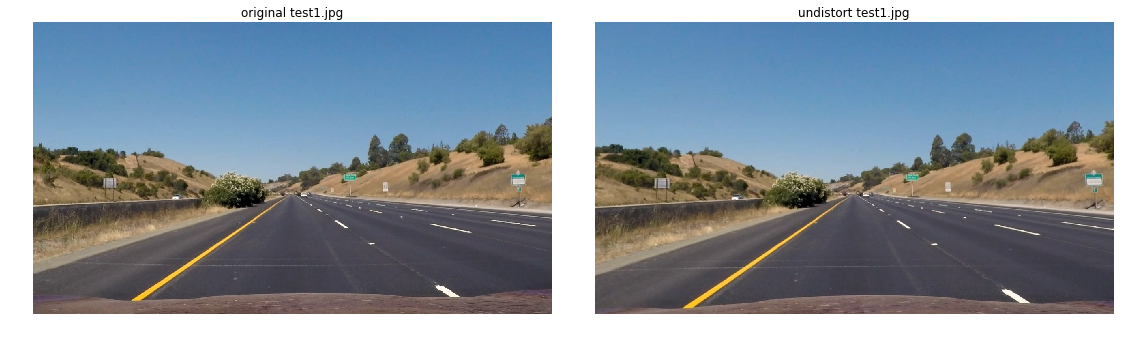

In [7]:
test1 = cv2.cvtColor(cv2.imread("./test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)
undist_test1 = cv2.undistort(test1, mtx, dist, None, mtx)
showImages([("original test1.jpg", test1), ("undistort test1.jpg", undist_test1)], 2, 1)

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps given in below few cells where `apply_thresholds` method will applies multiple thresholding schemes and combines them to extra lane pixels). 

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Extracts X or Y Gradients using Sobel operation
    
    Returns:
        binary_output (ndarray) - 1D binary image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(gray)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """
    Calculates and thresholds Gradient based on it's magnitude
    
    Returns:
        binary_output (ndarray) - 1D binary image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag > thresh[0]) & (gradmag < thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    """
    Calculates Gradient Direction and applies threshold (angle)
    
    Returns:
        binary_output (ndarray) - 1D binary image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)

    binary_output = np.zeros_like(grad_direction)
    binary_output[(grad_direction > thresh[0]) & (grad_direction < thresh[1])] = 1
    return binary_output


def hls_select(img, thresh=(0, 255), index=2):
    """
    Selects channel from HLS color space and applies thresholds
    
    Returns:
        binary_output (ndarray) - 1D binary image
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    selected = hls[:, :, index]
    
    binary_output = np.zeros_like(selected)
    binary_output[(selected > thresh[0]) & (selected <= thresh[1])] = 1
    return binary_output

In order to find lane pixels, various thresholding were applied as stated above, complete pipeline for processing image is given below in `apply_thresholds` function.

With some experiements, i concluded following fine tuned values for each threshold schemes

| Threshold Scheme   | Threshold value range | Kernel Size |
|:------------------:|:---------------------:|:-----------:|
| Gradient X         |       (20, 100)       |      7      |
| Gradient Y         |       (80, 255)       |      7      |
| Gradient Direction |       (0.7, 1.3)      |      15     |
| Gradient Magnitude |       (30, 100)       |      9      |
| HLS's S Channel    |       (170, 255)      |      -      |

Later I have cropped the thresholded binary image by the region where it is very likly Lane marking can be preset.

In [9]:
def apply_thresholds(image, display=True):
    """
    Apply different thresholding techiques to extract lane lines
    
    Returns:
        threshold (ndarray) - thresholded binary image
    """
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    height, width = image.shape[:2]
    
    # gradient threshold
    sx_binary = abs_sobel_thresh(image, 'x', sobel_kernel=7, thresh=(20, 100))
    sy_binary = abs_sobel_thresh(image, 'y', sobel_kernel=7, thresh=(80, 255))
    
    # gradient direction threshold
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3)) #13
    
    # magnitude gradient threshold
    mag_binary = mag_thresh(image, sobel_kernel=9, thresh=(30, 100)) #9

    # combine threshold
    combine_binary = np.zeros_like(dir_binary)
    combine_binary[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # color space - hls threshold
    s_binary = hls_select(image, thresh=(170, 255))
    
    # combine threshold
    color_binary = np.zeros_like(combine_binary)
    color_binary[(s_binary > 0) | (combine_binary > 0)] = 1
    
    # crop dst points
    left_bottom = (100, height)
    right_bottom = (width - 20, height)
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, height)
    inner_right_bottom = (1150, height)
    inner_apex1 = (700, 480)
    inner_apex2 = (650, 480)
    vertices = np.array([[left_bottom, apex1, apex2, 
                          right_bottom, inner_right_bottom, 
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    
    mask = np.zeros_like(color_binary)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(color_binary, mask)
    
    if display:
        showImages([("image", image), ("s_binary", s_binary), ("sx_binary", sx_binary),
                    ("sy_binary", sy_binary), ("mag_binary", mag_binary), ("dir_binary", dir_binary),
                    ("color_binary", color_binary), ("masked_image", masked_image)],
                   4, 2, figsize=(25, 7))
        
    return masked_image

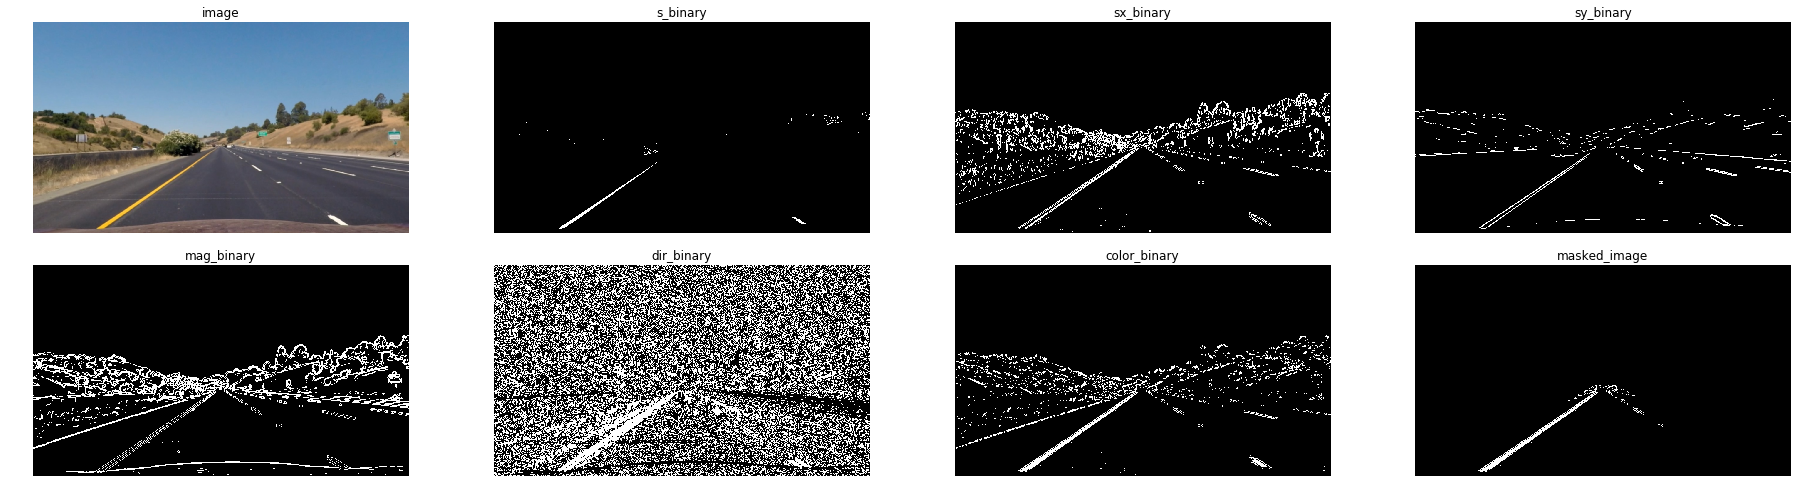

In [10]:
thresholded = apply_thresholds(undist_test1, True)

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warp_image()`, which appears in below cell. The `warp_image()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```python
    height, width = image.shape[:2]

    src = np.float32([[580, 460], 
                      [710, 460], 
                      [1150, 720], 
                      [150, 720]])

    dst = np.float32([[200, 0], 
                      [width - 200, 0], 
                      [width - 200, height], 
                      [200, height]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 580, 460      | 200 , 0       | 
| 710, 460      | 1080, 0       |
| 1100, 720     | 1080, 720     |
| 200, 720      | 200 , 720     |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In [11]:
def transform_points(width, height):
    """
    Forms Source/Destination points based on image dimensions
    
    Returns:
        src (ndarray) - Source Image points
        dst (ndarray) - Destination Image points
    """
    offset = 200
    src = np.float32([[580, 460], [710, 460], [1100, 720], [200, 720]])
    dst = np.float32([[offset, 0], [width - offset, 0], [width - offset, height], [offset, height]])

    return src, dst
    
def unwarp_image(image):
    """
    Performs Invert Perspective Transform to unwarp image
    
    Returns:
        unwarped (ndarray) - 2D unwarped image
    """
    height, width = image.shape[:2]
    
    src, dst = transform_points(width, height)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(image, Minv, (width, height))


def warp_image(image):
    """
    Performs Perspective Transform to warp image
    
    Returns:
        unwarped (ndarray) - 2D unwarped image
    """
    height, width = image.shape[:2]
    
    src, dst = transform_points(width, height)
    
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (width, height))

(-0.5, 1279.5, 756.025, -0.5)

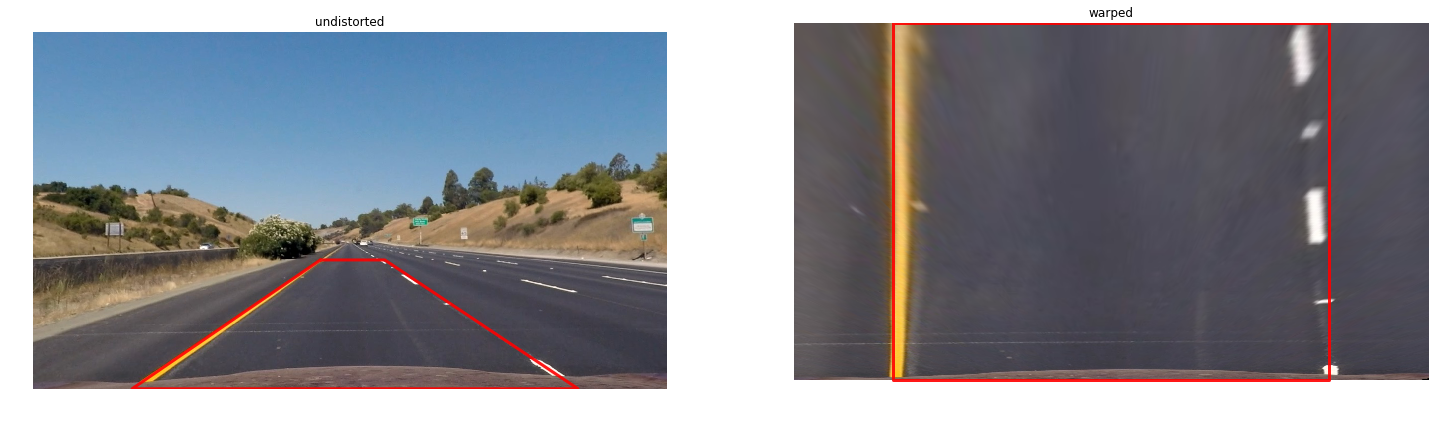

In [12]:
# warp test image
warped = warp_image(undist_test1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 20))
h, w = undist_test1.shape[:2]
src, dst = transform_points(w, h)
sx = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
sy = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
dx = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
dy = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
ax1.imshow(undist_test1)
ax1.plot(sx, sy, color='#ff0000', alpha=0.9, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title("undistorted")
ax1.axis('off')
ax2.imshow(warped)
ax2.plot(dx, dy, color='#ff0000', alpha=0.9, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_title("warped")
ax2.axis('off')

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

[image1]: ./examples/color_fit_lines.jpg "Fit Visual"

![atl text] [image1]

In [13]:
def fit_polynomial(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [14]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def find_pos(l_fit, r_fit, w, h):
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    car_position = w / 2
    l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
    r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist

def find_peaks(binary_warped):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

In [15]:
def sliding_window(binary_warped, left_lane, right_lane, nwindows=9, margin=100, minpix=50):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    leftx_base, rightx_base = find_peaks(binary_warped)
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    if not (left_lane.detected or right_lane.detected):
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                          (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                          (0, 255, 0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    else:
        left_fit = left_lane.current_fit[-1]
        right_fit = right_lane.current_fit[-1]
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
        
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)# if len(leftx) != 0 else None
    right_fit = np.polyfit(righty, rightx, 2)# if len(rightx) != 0 else None
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [16]:
def fitLines(binary_warped, left_lane, right_lane):
       
    binary_warped[binary_warped > 0] = 255
    
    left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window(binary_warped, left_lane, right_lane)
    
    ploty, left_fitx, right_fitx = fit_polynomial(binary_warped, left_fit, right_fit)

    left_curverad = find_curvature(ploty, left_fitx)
    right_curverad = find_curvature(ploty, right_fitx)

    left_lane.add_line(left_fit, left_lane_inds)
    right_lane.add_line(right_fit, right_lane_inds)

    return left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, left_curverad, right_curverad

def visualizeLines(binary_warped, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img

def visualizeLanes(undist, binary_warped, left_fitx, right_fitx, left_fit, right_fit, left_curve, right_curve):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    newwarp = unwarp_image(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    curvature = int((left_curve + right_curve) / 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(curvature)
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    #pts = np.argwhere(newwarp[:,:,1])
    #position = find_position(pts, undist.shape[1])
    h, w = binary_warped.shape[:2]
    position = find_pos(left_fit, right_fit, w, h)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    # plt.imshow(result)
    return result

#### Complete Pipeline

In [17]:
diag = False
def process_image(image, display=False):
    """
    Complete Pipeline 
    """
    # Undistort image 
    undist = cv2.undistort(image, mtx, dist)
    
    # Apply threshold schemes to extract Lanes
    threshold = apply_thresholds(image, False)
    
    # Perspective Transform to view top-down view of lanes
    warped = warp_image(threshold)
    
    # fit Lane Lines on top-down view of lanes
    lfx, rfx, lf, rf, l_ind, r_ind, lc, rc = fitLines(warped, left_lane, right_lane)
    
    # visualize lane lines on top-down view of lanes
    lanes_img = visualizeLines(warped, l_ind, r_ind)
    
    # Visualize lane lines on undistorted image 2D view
    result = visualizeLanes(undist, warped, lfx, rfx, lf, rf, lc, rc)
    
    if diag:
        threshold[threshold > 0] = 255
        thresh_3_channel = np.dstack((threshold, threshold, threshold))
        result1 = np.hstack((undist, result, ))
        result2 = np.hstack((thresh_3_channel, lanes_img))
        result = np.vstack((result1, result2))
    
    if display:
        showImages([("image", undist), ("thresh", threshold), 
                    ("lanes_img", lanes_img), ("result", result)], 
                   4, 1, figsize=(20, 9))
    return result

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #number of detected pixels
        self.pix_count = None
        
    def add_line(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100. and len(self.current_fit) > 5):
                self.detected = False
            else:
                self.detected = True
                self.pix_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit) - 5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit) - 1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)
                

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


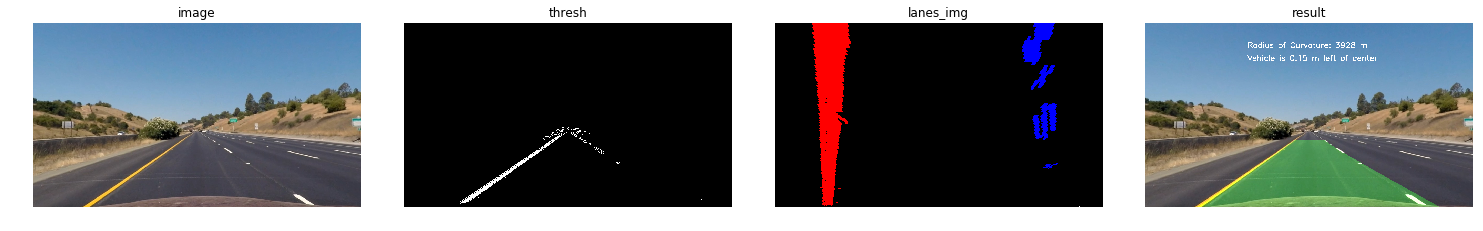

In [19]:
left_lane = Line()
right_lane = Line()
vis_in = process_image(undist_test1, display=True)

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in function `fitLanes` in above code cell.  Here is an example of my result on a test image:

(<matplotlib.image.AxesImage at 0x19a363c5860>,
 Text(0.5,1,'Lane area'),
 (-0.5, 1279.5, 719.5, -0.5))

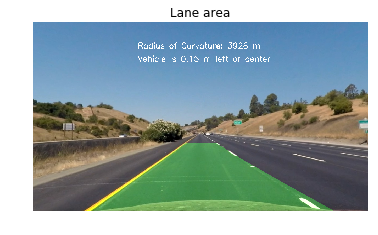

In [20]:
plt.imshow(vis_in), plt.title("Lane area"), plt.axis("off")

#### Run on all the test images

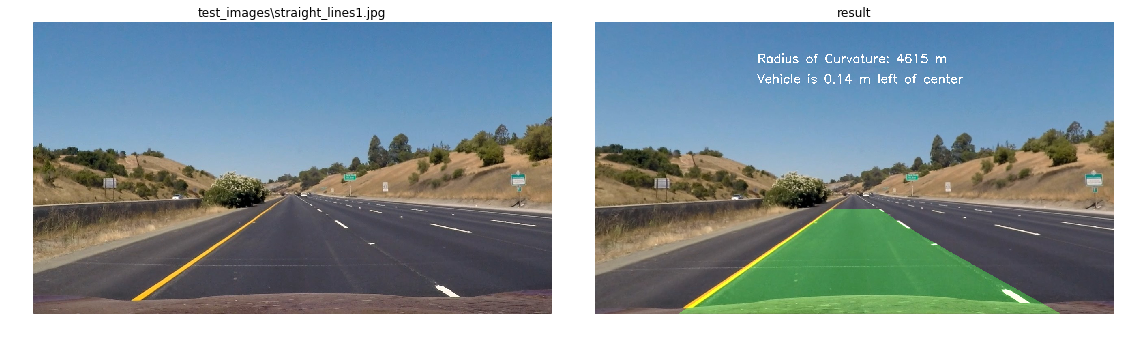

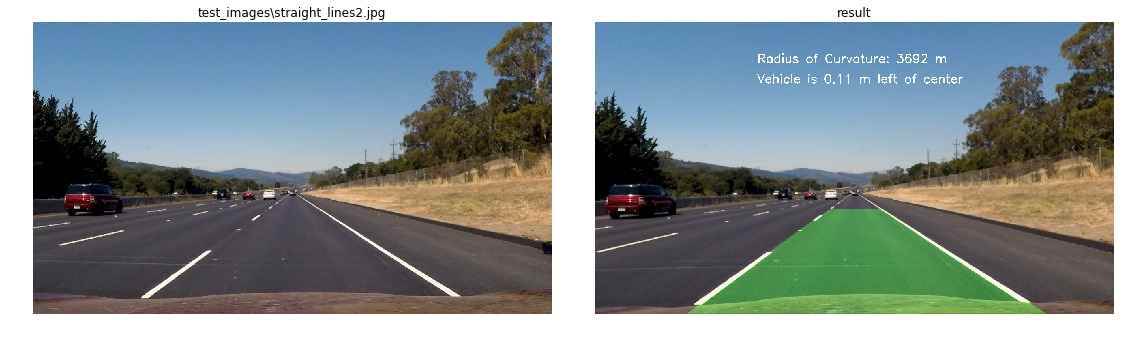

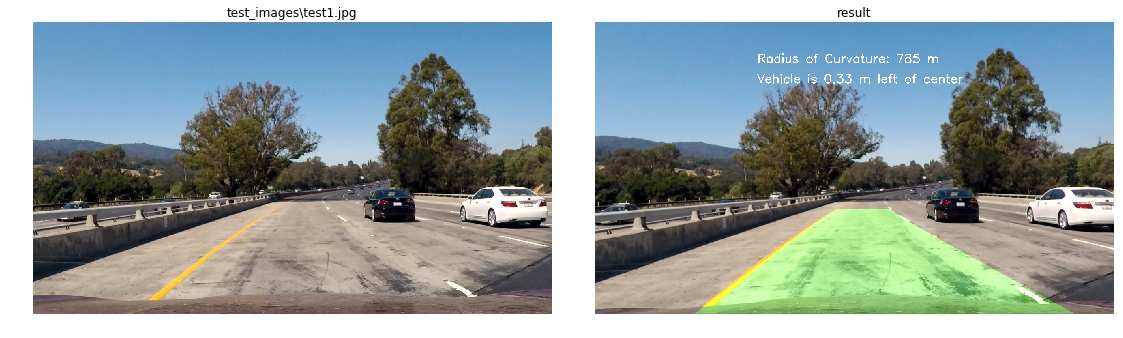

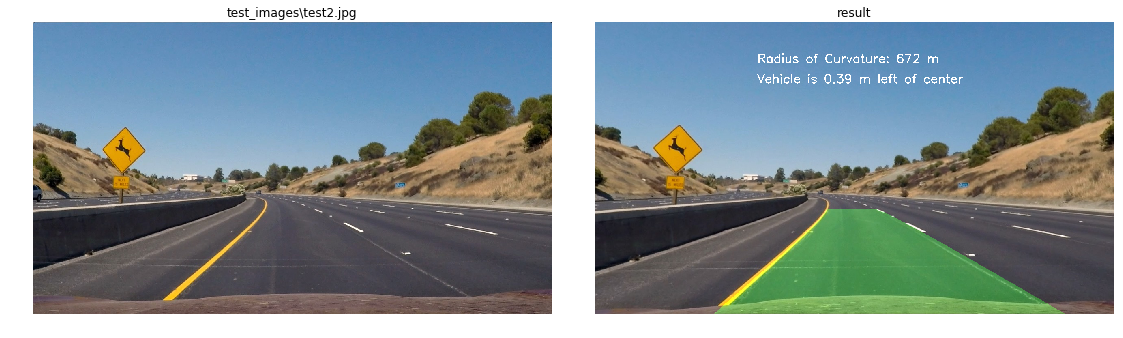

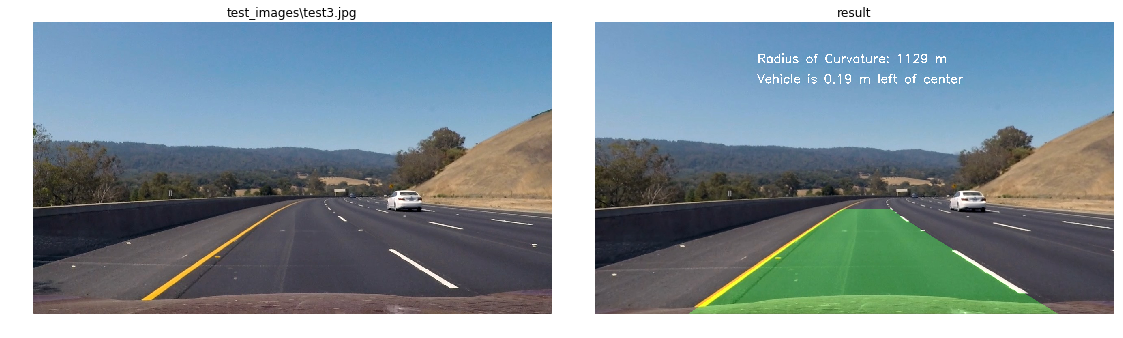

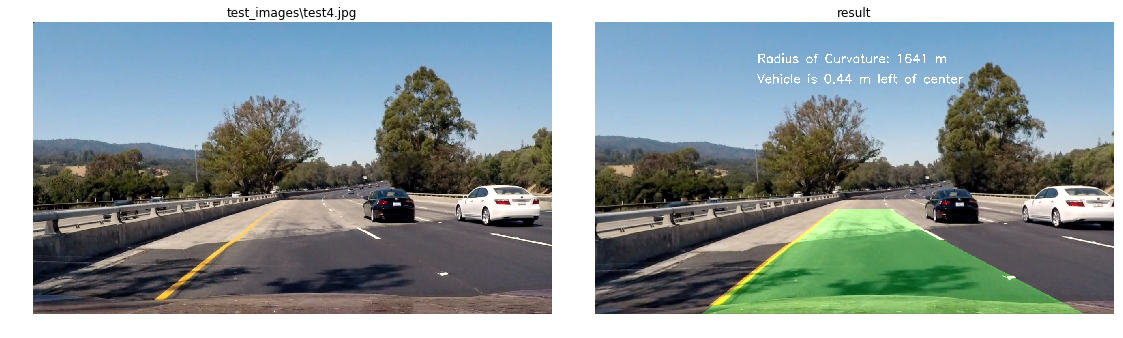

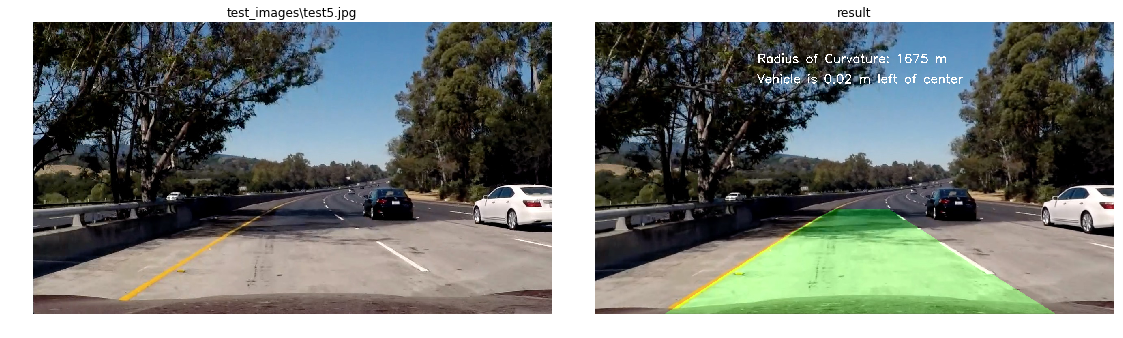

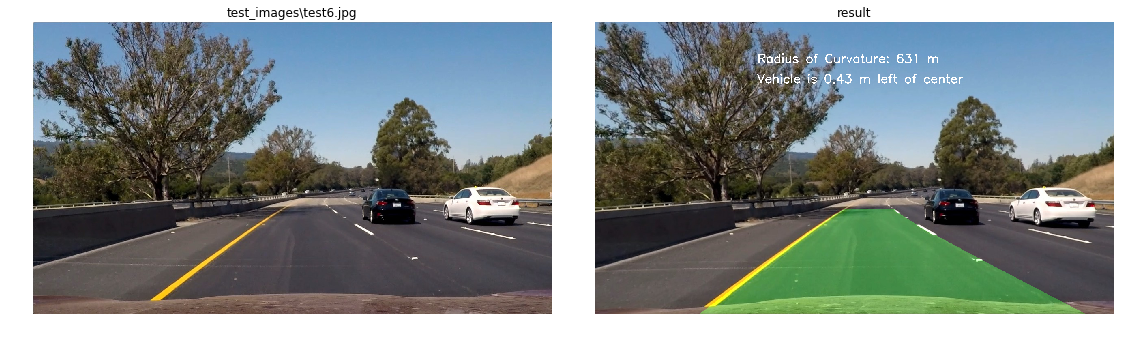

In [21]:
for fname, image in testImages:
    left_lane = Line()
    right_lane = Line()    
    result = process_image(image, display=False)
    
    showImages([(fname, image), ("result", result)], 2, 1)

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to project video](./project_video.mp4)

Here's a [link to my project video result](./result.mp4)

Here's a [link to my project video result with diagnostic info image](./result_diag.mp4)

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Project Video

In [23]:
left_lane = Line()
right_lane = Line()
diag = False
video_output1 = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip1 = clip1.fl_image(process_image)

%time result_clip1.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|████████████████████████████████▉| 1260/1261 [06:55<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 6min 56s


In [24]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="result.mp4" type="video/mp4">
</video></div>""")

#### Project Video (with diagnostic image previews)

In [25]:
left_lane = Line()
right_lane = Line()
diag = True
video_output2 = 'result_diag.mp4'
clip2 = VideoFileClip("project_video.mp4")
result_clip2 = clip2.fl_image(process_image)

%time result_clip2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video result_diag.mp4
[MoviePy] Writing video result_diag.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [09:31<00:00,  2.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_diag.mp4 

Wall time: 9min 32s


In [26]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="result_diag.mp4" type="video/mp4">
</video></div>""")

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The problems I encountered during the development phase was mostly during the thresholding, initially I tried applying thresholds on top-down view of lanes assuming that lanes will considerably work well. But at later stage I found that by doing so there were other stuffs such as car also gets thresholded and visible into the threshold image causing entire pipeline failure. In order to solve this issue now I first applied threshold and removed all the unwanted portion of image from detected threshold image, to avoid unwanted lane detection by applying crop to the Region of interest.

Although during my testing, I encountered that there are slight fluctuations in my lane region when lane markers are not correctly visible and lighting conditions changes, although current implementation is robust enough to keep car on track.

Future Improvements:
1. Multiple Lanes Detection: I saw that when thresholds were applied, and appropriate transform matrix used for converting image to top-down view, we can find multiple lanes as well. This requires to re-iterate the entire sliding window approach for mulitple lanes, and by this we not only detect our *EGO LANE* but also should be able to detect *LEFT LANE* and *RIGHT LANE* too.
2. Use of DNN might improve on accuracy and could be robust solution compared to threshold approach.